# Integrable Circuit Synthetic Benchmark

In [4]:
import sys
sys.path.insert(0, '../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary, random_clifford
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from kraus_channels import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde
from quantum_circuits import *
from analysis import *
from utils import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

path1 = "../../../data/"
path2 = "data/"

In [5]:
def generate_spam_benchmark(n=3, c1=1, c2=1):
    d = 2**n

    init_target = InitialState(d, c=c1)
    povm_target = POVM(d, c=c2)

    spam_target = SPAM(init = init_target,
                       povm = povm_target)
    
    return spam_target


def generate_spam_data(spam_target, N_spam=None, shots=1024):
    n = int(np.log2(spam_target.d))
    inputs_spam, _ = generate_pauliInput_circuits(n)
    N_spam = inputs_spam.shape[0]

    state = tf.repeat(spam_target.init.init[None,:,:], N_spam, axis=0)
    targets_spam = measurement(state, U_basis = inputs_spam, povm = spam_target.povm.povm)

    #add noise
    targets_spam = add_shot_noise(targets_spam, shots = shots)
    return inputs_spam, targets_spam


def generate_map_data(channel_target, spam_target, N_map=None, shots=1024):
    n = int(np.log2(channel_target.d))
    inputs_map, _ = generate_pauli_circuits(n = n, 
                                            circuit_target=None,  
                                            trace=False,
                                            N=N_map)
    U_prep, U_basis = inputs_map

    N_map = U_prep.shape[0]
    state = tf.repeat(tf.expand_dims(spam_target.init.init, axis=0), N_map, axis=0)
    state = apply_unitary(state, U_prep)
    state = channel_target.apply_channel(state)
    targets_map = measurement(state, U_basis, spam_target.povm.povm)
    
    #add noise
    targets_map = add_shot_noise(targets_map, shots = shots)

    return inputs_map, targets_map

## Four Qubit

In [8]:
n = 4
d = 2**n
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_target = generate_spam_benchmark(n=n, c1=0.9, c2=0.9)
inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, shots=1024)

In [23]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

U = circuit_to_matrix(nonintegrable_circuit(n, 4))

channel_target1 = DilutedKrausMap(U = generate_unitary(d), 
                                  c = 0.69,
                                  kraus_part = KrausMap(d=d, 
                                                        rank=8),
                                  spam = spam_target)

inputs_map1, targets_map1 = generate_map_data(channel_target1, spam_target, N_map= 10000-6**n, shots=1024)

In [15]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

spam_model = SPAM(init = InitialState(d, c=0.9),
                  povm = CorruptionMatrix(d, c=0.9),
                  loss_function = ProbabilityMSE(),
                  optimizer = tf.optimizers.Adam(learning_rate=0.01)
                 )

spam_model.train(inputs = inputs_spam,
                targets = targets_spam,
                num_iter = 2000,
                verbose = False,
                )

  0%|          | 0/2000 [00:00<?, ?it/s]

Spam loss:  0.0008143422707853413


In [16]:
model = ModelQuantumMap(channel = KrausMap(d = d, 
                                            rank = d**2,
                                            spam = spam_model,
                                            ),
                        loss_function = ProbabilityMSE(),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        logger = Logger(loss_function = ProbabilityMSE(),
                                        loss_function_val = channel_fidelity_loss),
                       )

model.train(inputs = inputs_map,
            targets = targets_map,
            inputs_val = None,
            targets_val = [channel_target],
            num_iter = 2000,
            N = 500,
            )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.2946999935302998 -0.022358534920997413
0.13847579680745983 -0.18678727534523615
0.024795283913263966 -0.49600937118507676
0.019140972396049456 -0.574541936734369
0.018392001866356814 -0.6155044944491288
0.017223045562335317 -0.6556886543948656
0.016335143898222028 -0.6943069028962034
0.01542618239271744 -0.7297291106955597
0.015141414734036388 -0.7604232249655555
0.015285257502799151 -0.7857087498930567
0.014448197299078312 -0.8069061905596245
0.014300712907461058 -0.824306812243572
0.014351586101288775 -0.8380572050124366
0.014155625503524423 -0.8492218076801581
0.014288872939844677 -0.8586448736317157
0.013970588786027019 -0.8659913732552753
0.014417739550801311 -0.8716278405955464
0.013722319754637642 -0.8763653987015649
0.014392195372183227 -0.8805311765465323
0.014135929743980131 -0.8835122239199099
0.013760411258029294 -0.8861466264350039


In [29]:
spectrum_target1 = channel_spectrum(channel_target1)
spectrum_model1 = channel_spectrum(model.channel) 

c:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\krist\AppData\Local\Temp\ipykernel_113852\1714468177.py:13: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002138D666170> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Model", "Target"], loc="lower right")


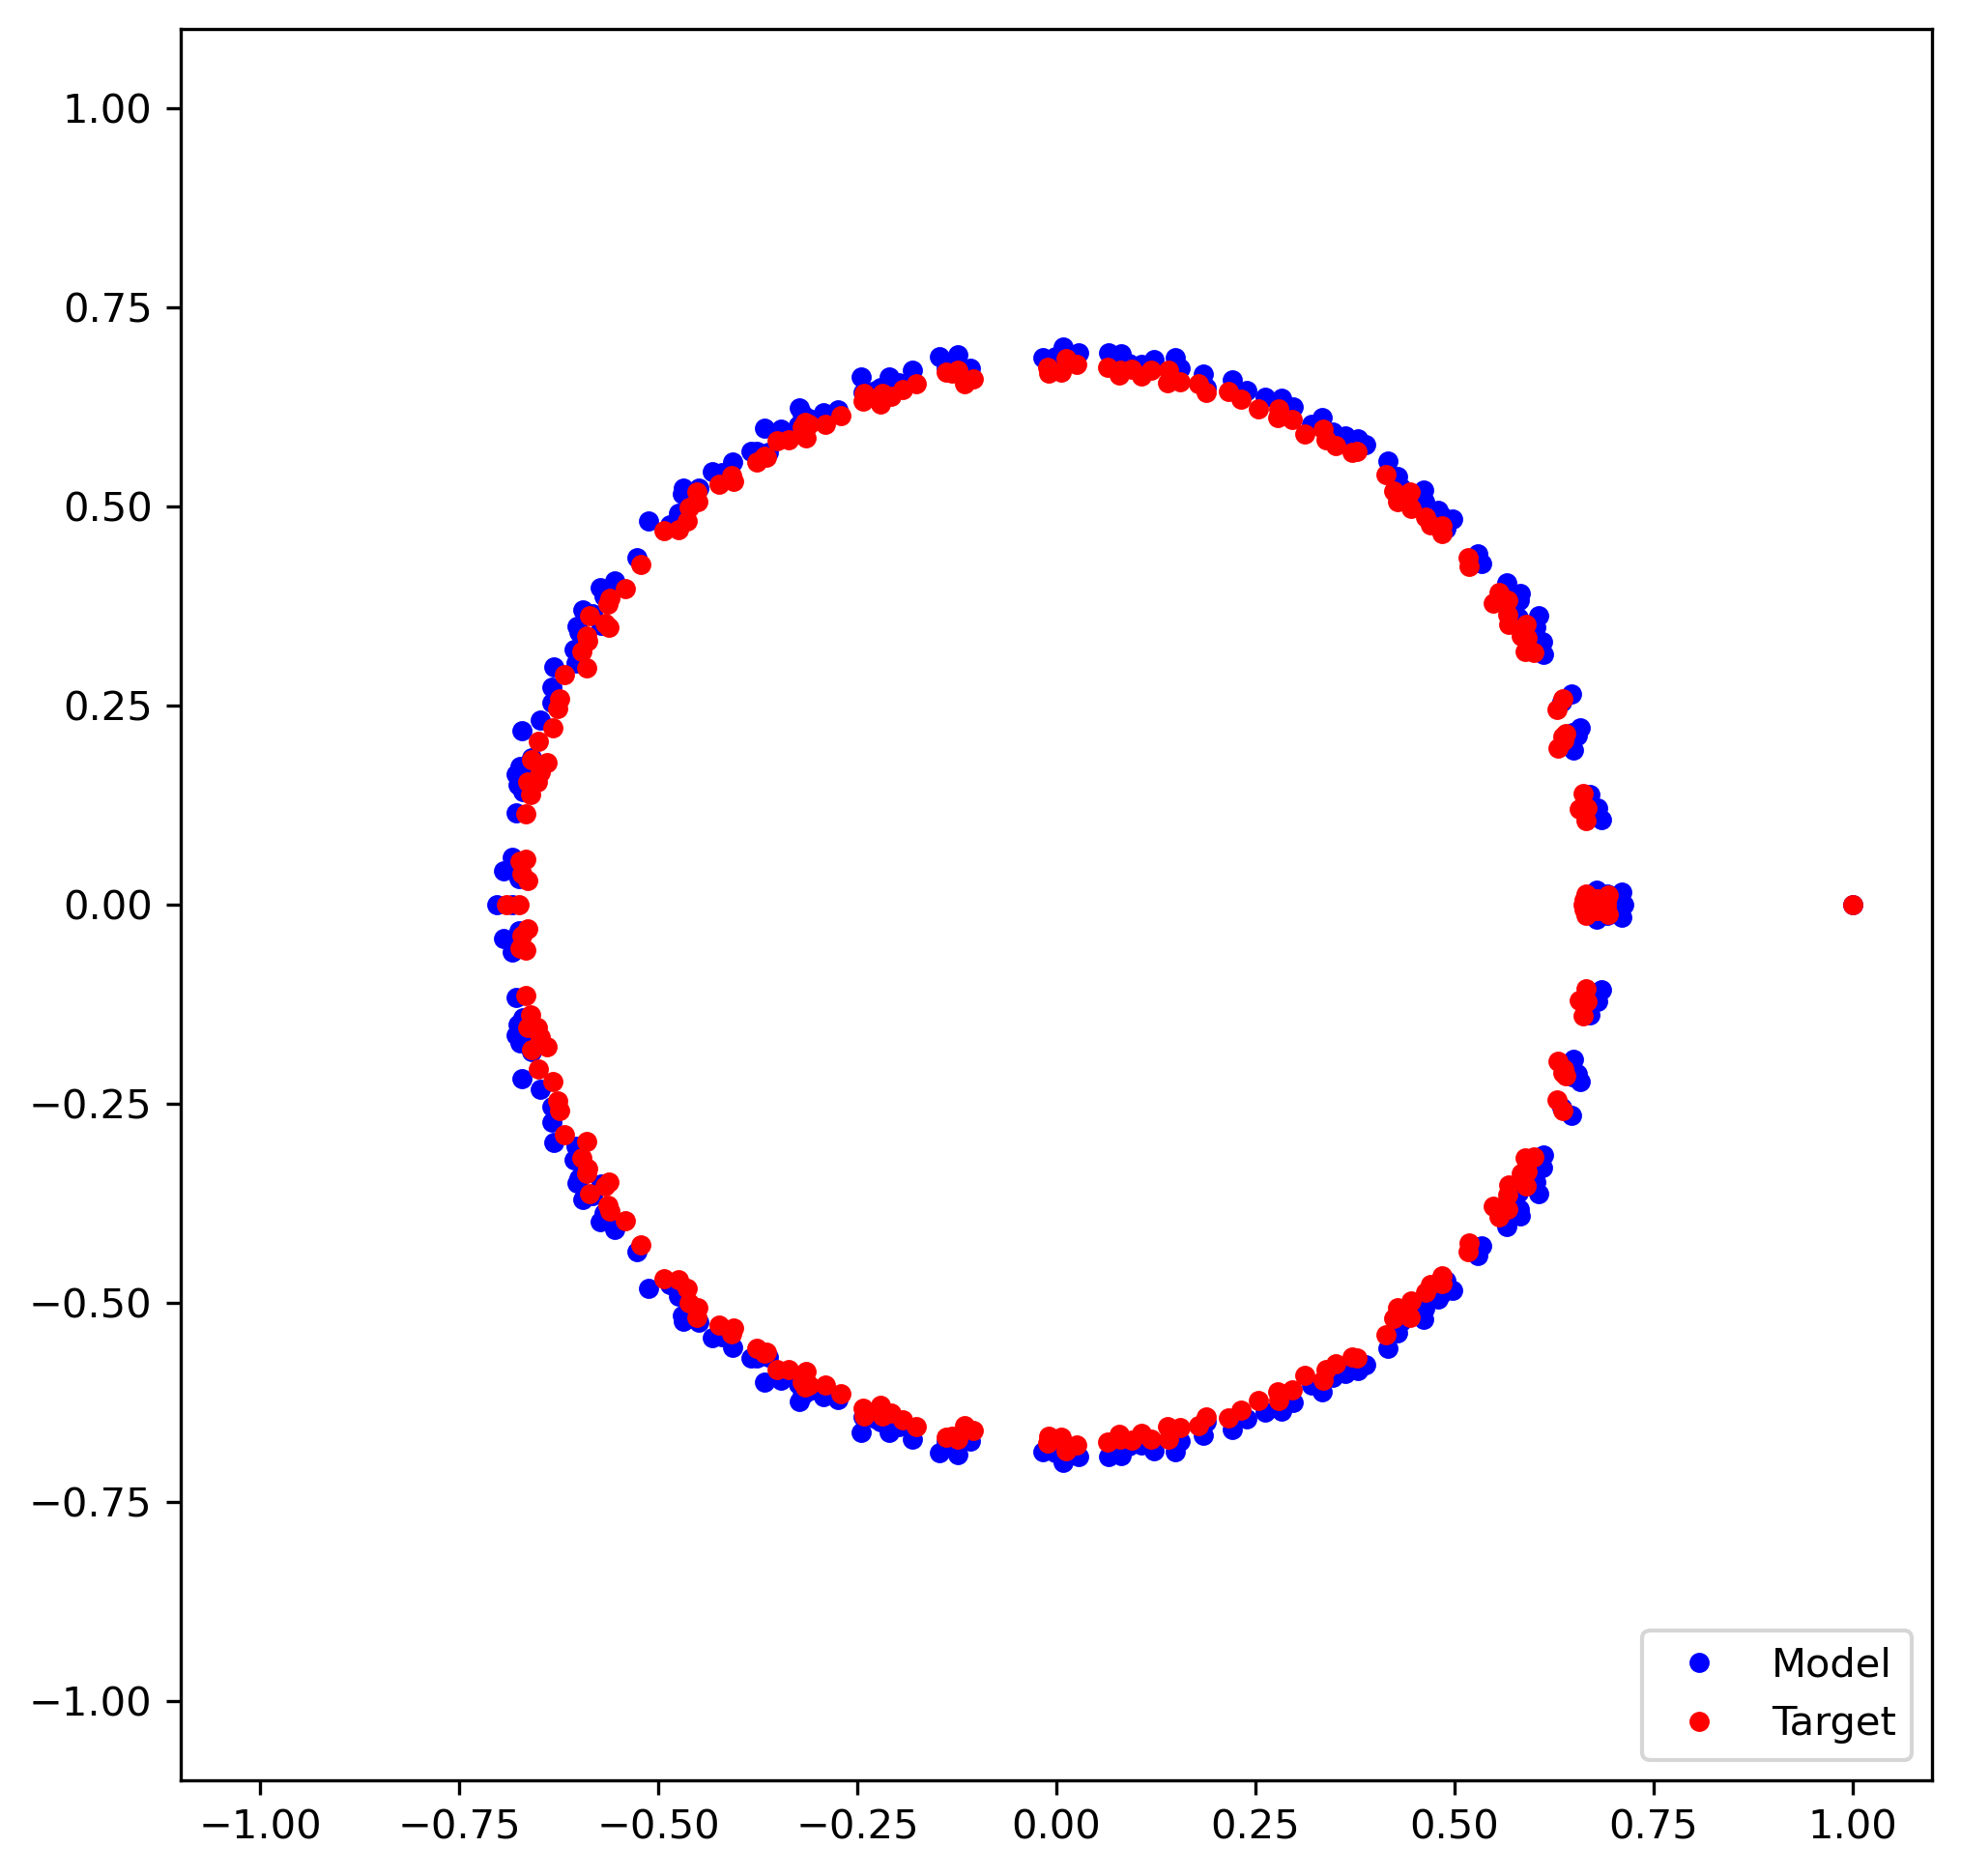

In [32]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

plt.plot(*circle, "w")
plt.plot(spectrum_target1[:,0], spectrum_target1[:,1], "bo", markersize=4)
plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "ro", markersize=4)


plt.legend(["_", "Model", "Target"], loc="lower right")
plt.savefig("figures/" + "synthetic_4qubit_nonintegrable_medium.pdf", bbox_inches='tight')
plt.show()

In [25]:
np.random.seed(47)
random.seed(47)
tf.random.set_seed(47)

U = circuit_to_matrix(integrable_circuit(n, 4))

channel_target2 = DilutedKrausMap(U = U, 
                                  c = 0.69,
                                  kraus_part = KrausMap(d=d, 
                                                        rank=8),
                                  spam = spam_target)

inputs_map2, targets_map2 = generate_map_data(channel_target2, spam_target, N_map= 10000-6**n, shots=1024)

In [21]:
model2 = ModelQuantumMap(channel = KrausMap(d = d, 
                                            rank = d**2,
                                            spam = spam_model,
                                            ),
                        loss_function = ProbabilityMSE(),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        logger = Logger(loss_function = ProbabilityRValue(),
                                        loss_function_val = channel_fidelity_loss),
                       )

model2.train(inputs = inputs_map,
            targets = targets_map,
            inputs_val = None,
            targets_val = [channel_target],
            num_iter = 2000,
            N = 500,
            )

  0%|          | 0/2000 [00:00<?, ?it/s]

-0.005457892227965555 -0.021294515575269693
0.515245960061087 -0.12465767187783632
0.8896259613910658 -0.3938643460133155
0.9452044886642971 -0.5307347857554523
0.9512192481272281 -0.5919726383885043
0.9547233880751239 -0.6431642076483041
0.9563947673464388 -0.6875431456279066
0.9574914098435258 -0.7253613956942614
0.9573077236331023 -0.7573214595506755
0.9615570066641229 -0.7835566525403045
0.9614437397137241 -0.805055022262837
0.9628521947359001 -0.8224670483423902
0.9637676862430179 -0.8368750598185069
0.9646758767964818 -0.8483779116609612
0.9639643289178035 -0.8577794595321119
0.9643160888601204 -0.865213122126915
0.9646451753603239 -0.8711776255970202
0.963355770820496 -0.8762574508071157
0.9642400546993571 -0.8800787115452201
0.9663690228722871 -0.8835411265633824
0.9629938492121821 -0.8859092885959631


In [26]:
spectrum_target2 = channel_spectrum(channel_target2)
spectrum_model2 = channel_spectrum(model2.channel)

#TODO diff in channel fid -/-> diff in spectrum

c:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\krist\AppData\Local\Temp\ipykernel_113852\2825414962.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002138D677D90> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Model", "Target"], loc="lower right")


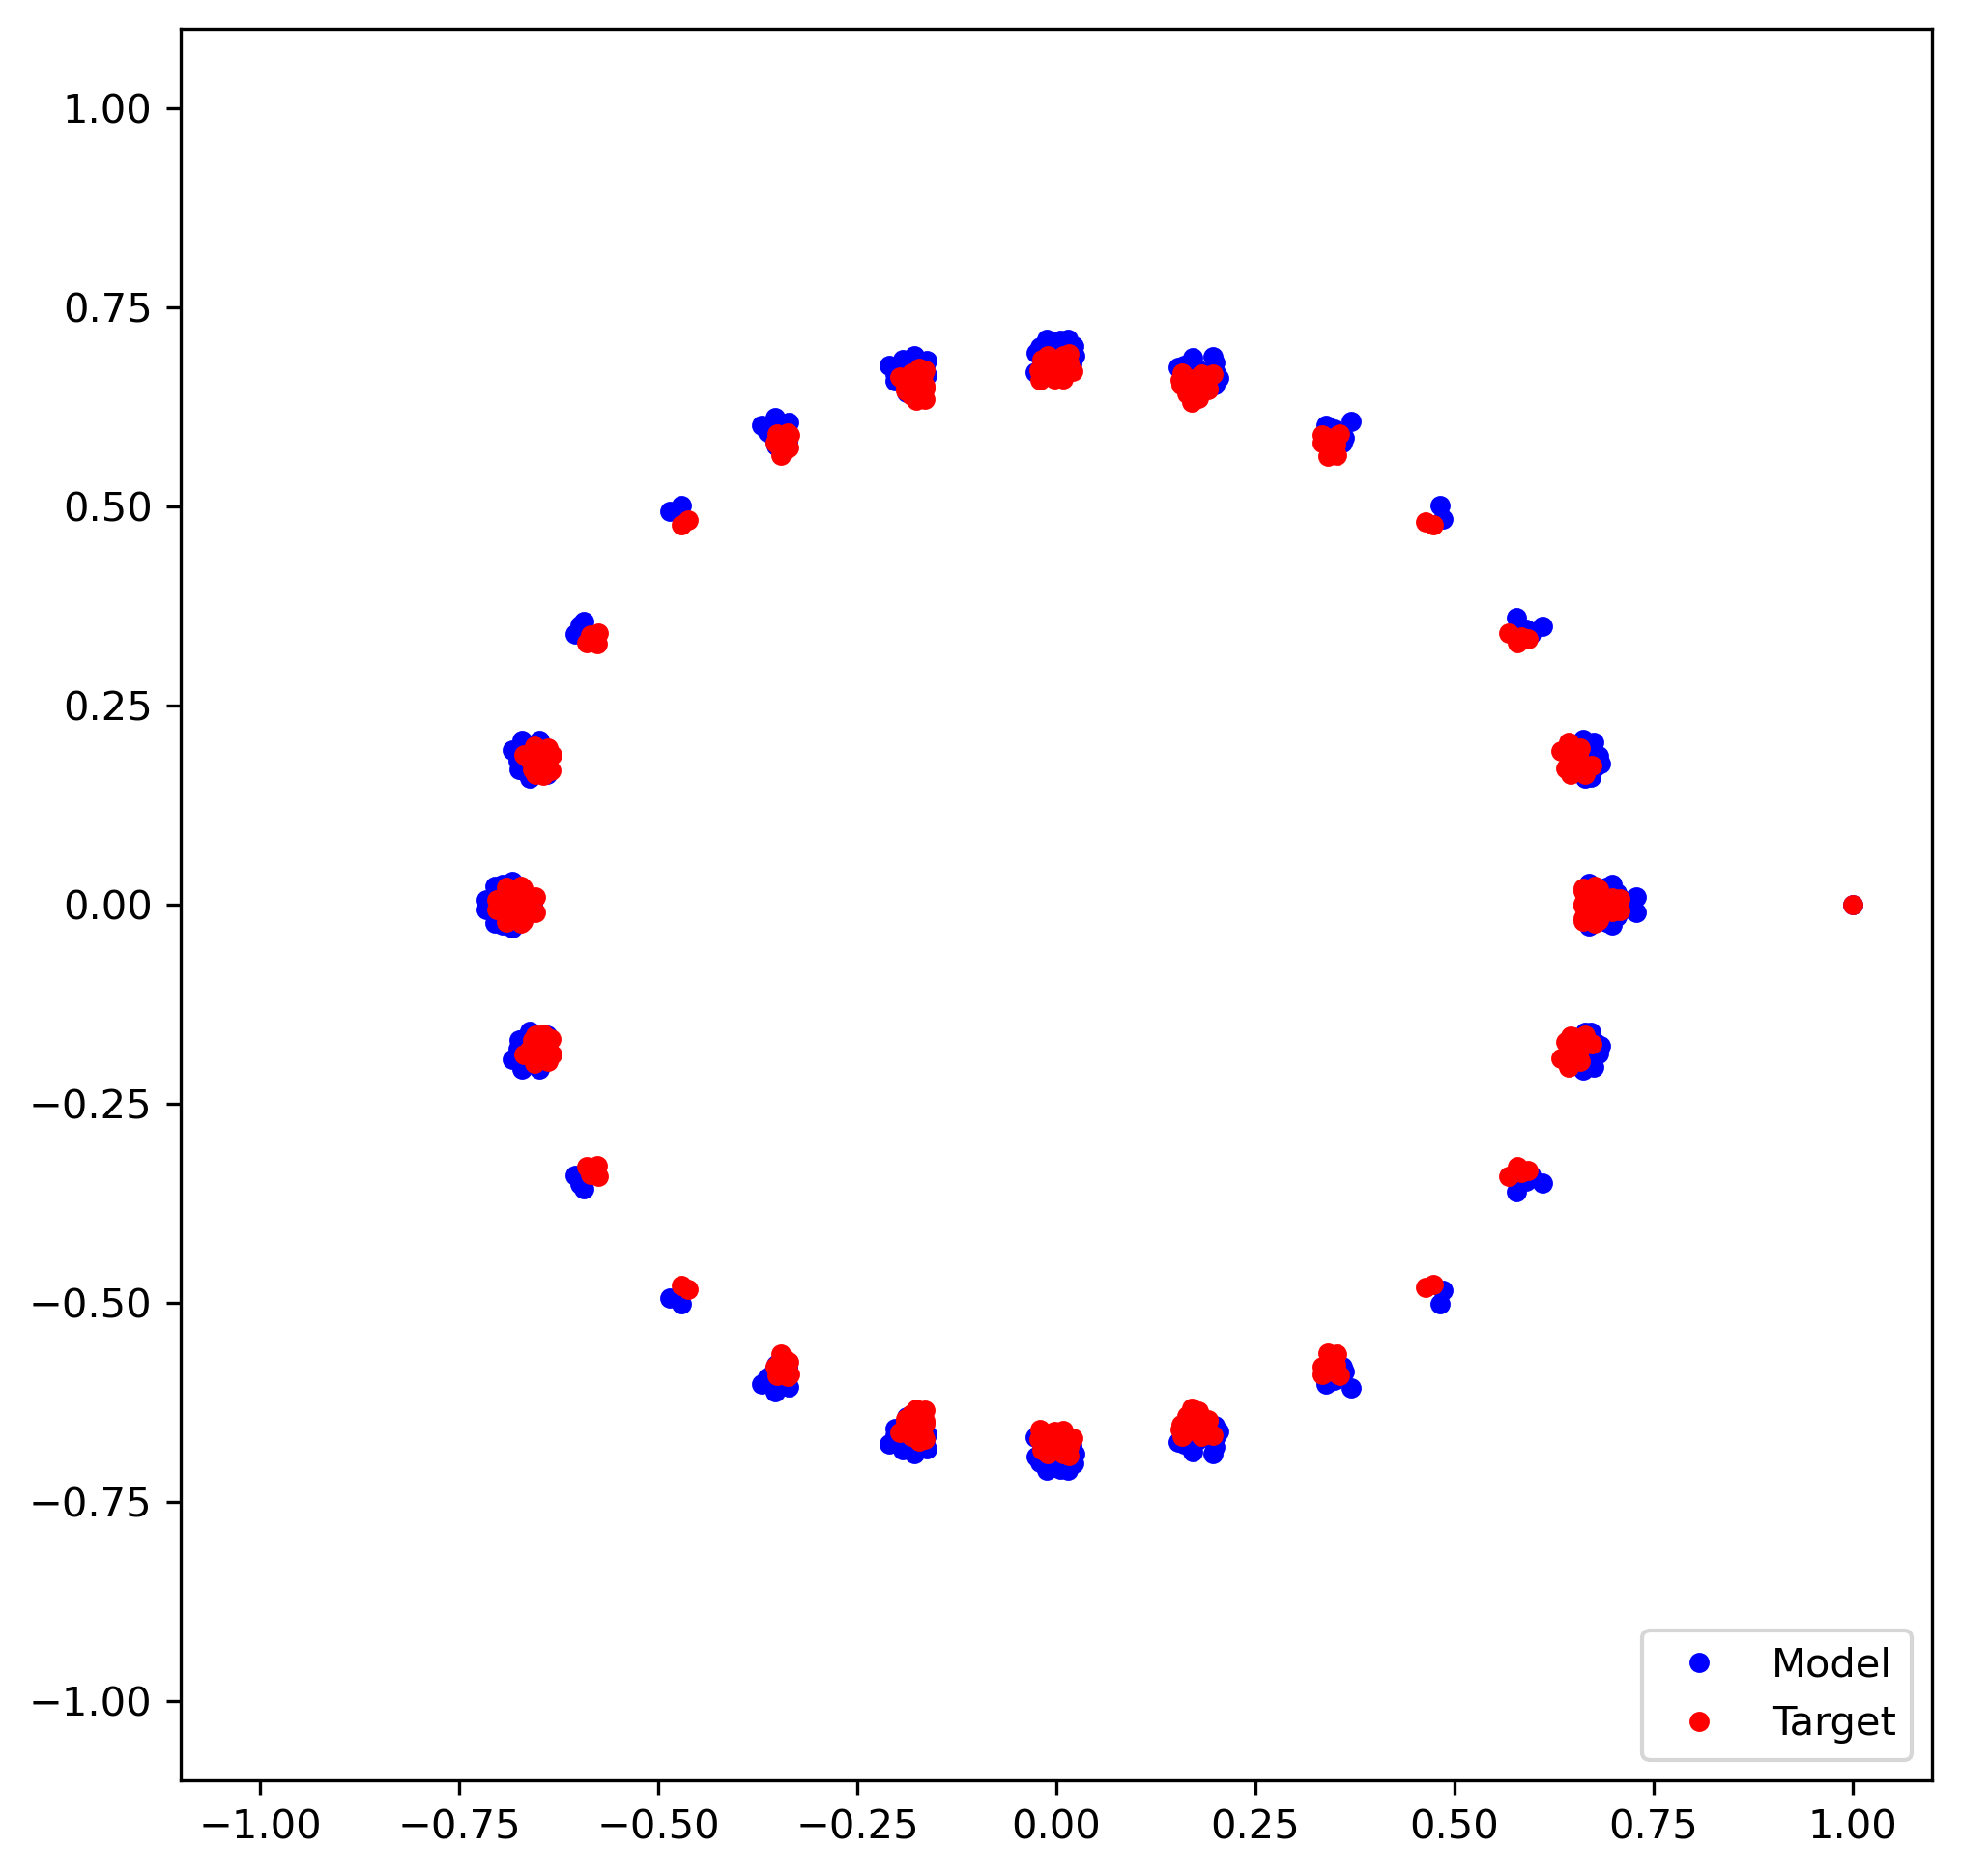

In [33]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

plt.plot(*circle, "w")
plt.plot(spectrum_target2[:,0], spectrum_target2[:,1], "bo", markersize=4)
plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "ro", markersize=4)

plt.legend(["_", "Model", "Target"], loc="lower right")
plt.savefig("figures/" + "synthetic_4qubit_integrable_medium.pdf", bbox_inches='tight')
plt.show()